<a href="https://colab.research.google.com/github/Kryptera-K/AVGO-Multi-Oscillator-Weakness-Entry-Model/blob/main/AVGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AVGO"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AVGO_clean.csv", index=False)
df

/tmp/ipython-input-1047848233.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2009-08-06,1.141955,1.193477,1.098197,1.164540,241978000
2009-08-07,1.159600,1.182891,1.131369,1.139838,24543000
2009-08-10,1.127134,1.173715,1.101726,1.173715,24210000
2009-08-11,1.105961,1.129251,1.093962,1.127840,23054000
2009-08-12,1.129251,1.143367,1.105255,1.139838,14513000
...,...,...,...,...,...
2025-11-20,346.820007,376.079987,345.179993,366.000000,28867000
2025-11-21,340.200012,348.600006,331.799988,345.160004,30280300
2025-11-24,377.959991,382.000000,347.660004,347.730011,47262400


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
BEAR_POWER_SHIFT = 5
CCI_LEVEL = 0
CCI_PERIOD = 14
CCI_SHIFT = 5
CCI_SHIFT_2 = 10
KVO_LEVEL = 0
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13
STOCHASTIC_D_PERIOD = 3
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_OVERBOUGHT = 80
STOCHASTIC_OVERSOLD = 20

# -------------------------
# Indicator Functions
# -------------------------

def fast_k_lower_than_slow_d(df):
    df = calculate_stochastic(df)
    return df['Fast_%K'] < df['Slow_%D']


def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    """Calculate Fast %K and Slow %D"""
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def cci_falling(df, period=CCI_PERIOD, shifts=CCI_SHIFT):
    df['CCI_main'] = calculate_cci(df, period)['CCI']
    return df['CCI_main'] < df['CCI_main'].shift(shifts)


def calculate_cci(df, period=CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def kvo_cross_below_level(df, level=KVO_LEVEL):
    df = klinger_volume_oscillator(df)
    kvo = df['KVO']
    return (kvo < level) & (kvo.shift(1) >= level)


def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)
    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()
    return df


def bears_power_higher_than(df, period = BEAR_EMA_PERIOD, level=BEAR_POWER_LEVEL):
    df = calculate_bears_power(df, period)
    return df['Bears_Power'] > level


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    """Calculate Bears Power indicator and return updated DataFrame"""
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Stochastic_Fast_%K_Lower_Than_Slow_%D"] = fast_k_lower_than_slow_d(df)
df["CCI_Falling"] = cci_falling(df)

# -------------------------
# Exit conditions
# -------------------------

df["KVO_Cross_Below_Zero"] = kvo_cross_below_level(df)
df["BearP_Higher_0"] = bears_power_higher_than(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Stochastic_Fast_%K_Lower_Than_Slow_%D',
    'CCI_Falling',
]
exit_conditions = [
    'KVO_Cross_Below_Zero',
    'BearP_Higher_0',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                         2009-08-06 00:00:00
End                           2025-11-26 00:00:00
Period                         4104 days 00:00:00
Start Value                              100000.0
End Value                          44318326.82695
Total Return [%]                     44218.326827
Benchmark Return [%]                 33004.905705
Max Gross Exposure [%]                      100.0
Total Fees Paid                     457530.829788
Max Drawdown [%]                        49.276858
Max Drawdown Duration           311 days 00:00:00
Total Trades                                   54
Total Closed Trades                            53
Total Open Trades                               1
Open Trade PnL                     1425843.229652
Win Rate [%]                            83.018868
Best Trade [%]                         103.906031
Worst Trade [%]                        -17.441073
Avg Winning Trade [%]                   18.626904
Avg Losing Trade [%]                    -7.574896


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2009-08-06 00:00:00
End                           2025-11-26 00:00:00
Period                         4104 days 00:00:00
Start Value                              100000.0
End Value                         33104905.704594
Total Return [%]                     33004.905705
Benchmark Return [%]                 33004.905705
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        49.276858
Max Drawdown Duration           348 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                    33004905.704594
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2839810999.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


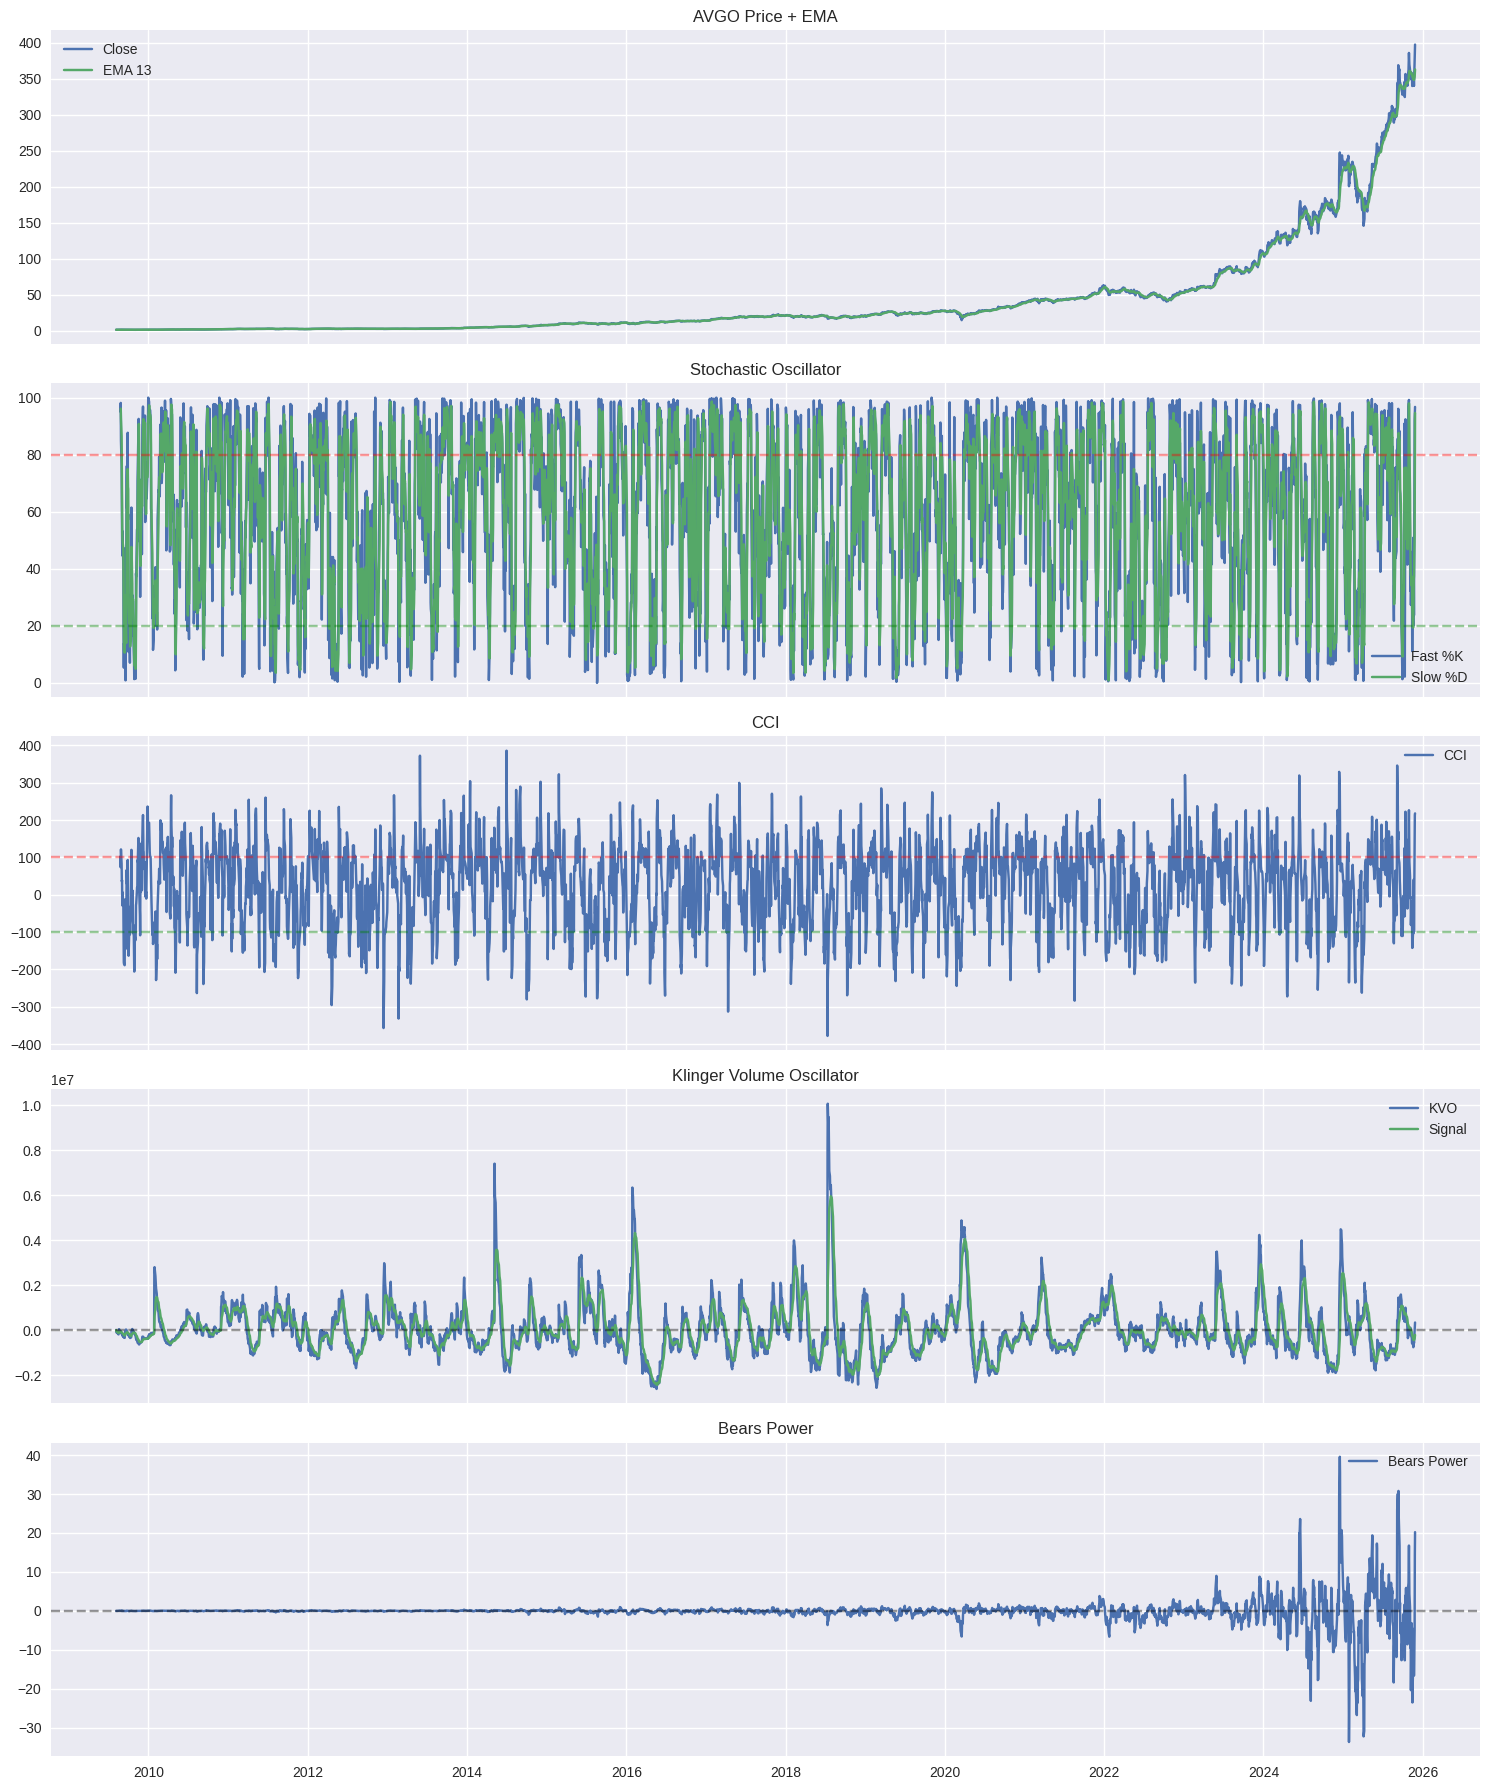

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "AVGO"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df = df.dropna()


# -------------------------
# Indicator Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
CCI_PERIOD = 14
CCI_SHIFT = 5
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13
STOCHASTIC_D_PERIOD = 3
STOCHASTIC_K_PERIOD = 14


# -------------------------
# Indicator Functions
# -------------------------

def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def calculate_cci(df, period=CCI_PERIOD):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)
    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()
    return df


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df


# -------------------------
# Compute All Indicators
# -------------------------

df = calculate_stochastic(df)
df = calculate_cci(df)
df = klinger_volume_oscillator(df)
df = calculate_bears_power(df)


# -------------------------
# Plotting
# -------------------------

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(5, 1, figsize=(15, 18), sharex=True)

# Price Chart
axes[0].plot(df.index, df['Close'], label="Close")
axes[0].plot(df.index, df['EMA'], label=f"EMA {BEAR_EMA_PERIOD}")
axes[0].set_title("AVGO Price + EMA")
axes[0].legend()

# Stochastic
axes[1].plot(df.index, df['Fast_%K'], label="Fast %K")
axes[1].plot(df.index, df['Slow_%D'], label="Slow %D")
axes[1].axhline(80, color="red", linestyle="--", alpha=0.4)
axes[1].axhline(20, color="green", linestyle="--", alpha=0.4)
axes[1].set_title("Stochastic Oscillator")
axes[1].legend()

# CCI
axes[2].plot(df.index, df['CCI'], label="CCI")
axes[2].axhline(100, color="red", linestyle="--", alpha=0.4)
axes[2].axhline(-100, color="green", linestyle="--", alpha=0.4)
axes[2].set_title("CCI")
axes[2].legend()

# KVO
axes[3].plot(df.index, df['KVO'], label="KVO")
axes[3].plot(df.index, df['KVO_Signal'], label="Signal")
axes[3].axhline(0, color="black", linestyle="--", alpha=0.4)
axes[3].set_title("Klinger Volume Oscillator")
axes[3].legend()

# Bears Power
axes[4].plot(df.index, df['Bears_Power'], label="Bears Power")
axes[4].axhline(0, color="black", linestyle="--", alpha=0.4)
axes[4].set_title("Bears Power")
axes[4].legend()

plt.tight_layout()
plt.show()
